In [6]:
import sys

sys.path.append('/mnt/sdceph/users/nroy/radmc3d-2.0/python/radmc3dPy')
sys.path.append('/mnt/home/nroy/test/chimes-IGNIS/chimes-driver/ext-lib/pfh_python')

#from simpleplot import *
#from radmc3dPy import image
#from gizmopy.load_from_snapshot import load_from_snapshot
#from gizmopy.load_fire_snap import load_fire_snap
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.facecolor']='w'


params = {"text.color" : 'k',
          "ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}

plt.rcParams.update(params)

'''
for generalization, see "#CHANGE" throughout code on lines where needs change depending on emission line instance (ctrl+f tofind and change quickly), most changes should be covered by changing the parent variable below.
''';

In [7]:
''' READ IN OF NECESSARY FILES, LIST (CII, OIII, CO, 4th?) '''
'''
CII_0 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/rotations/0deg/CII_158mu/"
CII_48 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/rotations/48deg/CII_158mu/"
CII_70 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/rotations/70deg/CII_158mu/"
CII_90 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/rotations/90deg/CII_158mu/"

CO_0 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/rotations/0deg/CO_J10/"
CO_48 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/rotations/48deg/CO_J10/"
CO_70 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/rotations/70deg/CO_J10/"
CO_90 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/rotations/90deg/CO_J10/"

OIII_0 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/rotations/0deg/OIII_5007A/"
OIII_48 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/rotations/48deg/OIII_5007A/"
OIII_70 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/rotations/70deg/OIII_5007A/"
OIII_90 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/rotations/90deg/OIII_5007A/"
'''


NII_0 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/60kpc/rotations/0deg/NII_6585A/"
NII_48 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/60kpc/rotations/48deg/NII_6585A/"
NII_70 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/60kpc/rotations/70deg/NII_6585A/"
NII_90 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/60kpc/rotations/90deg/NII_6585A/"

#CII_list = [CII_0, CII_48, CII_70, CII_90]
#CO_list = [CO_0, CO_48, CO_70, CO_90]
#OIII_list = [OIII_0, OIII_48, OIII_70, OIII_90]
NII_list = [NII_0, NII_48, NII_70, NII_90]

In [13]:
CII_vsigma = []
for l in CII_list:
    filepath_tot = l + 'image_tot.hdf5'
    filepath_con = l + 'image_continuum.hdf5'
    file_con = h5.File(filepath_con,'r')
    file_tot = h5.File(filepath_tot,'r')

    npix_x = np.shape(file_tot['image_array'][:])[0]
    npix_y = np.shape(file_tot['image_array'][:])[1]

    image_array = file_tot['image_array'][:] - file_con['image_array'][:]

    image_array[image_array < 0] = 0

    frequency_array = 3e8 / (file_tot['lambda_array'][:] * 1e-6)

    #moment 0
    integrated_image_array_moment0 = np.zeros((npix_x, npix_y))
    delta_nu = np.abs(frequency_array[1:] - frequency_array[:-1])
    for i in range(npix_x):
        for j in range(npix_y):
            integrated_image_array_moment0[i, j] = np.sum(delta_nu * (image_array[i, j, :-1] + image_array[i, j, 1:]) / 2.0)

    integrated_image_array_moment0[0,0] = 0 #final moment 0 array
    moment_0 = np.asarray(integrated_image_array_moment0) 

    #moment 1
    lambda_0_dict = {"CII_158mu": 157.62730407714844,
         "NII_6548A": 0.6545339822769165,
         "OI_6300A": 0.62976968288421631,
         "OI_63mu": 63.141555786132812,
         "OI_145mu": 145.43453979492188,
         "OIII_5007A": 0.50047838687896729,
         "OIII_88mu": 88.295417785644531,
         "OIV_25mu": 25.87542724609375,
         "NeII_12mu": 12.804655075073242,
         "NeIII_15mu": 15.543784141540527,
         "NeIII_3869A" : 0.3867171793754335,
         "NeV_14mu": 14.316787719726562,
         "NeV_3426A" : 0.34246401541369015,
         "NeVI_7mu": 7.6469192504882812,
         "SII_6716A": 0.67136573791503906,
         "SII_6731A": 0.67280274629592896,
         "SIII_18mu": 18.69268798828125,
         "CO_J10": 2600.757634}

    lambda_0 = lambda_0_dict["CII_158mu"]
    lambda_array = np.array(file_con['lambda_array'])
    velocity_arr = (lambda_array - lambda_0) * 3e5 / lambda_array 


    moment1_noint = velocity_arr * image_array

    integrated_image_array_moment1 = np.zeros((npix_x, npix_y))

    for i in range(npix_x):
        for j in range(npix_y):
            integrated_image_array_moment1[i, j] = np.sum(delta_nu * (moment1_noint[i, j, :-1] + moment1_noint[i, j, 1:]) / 2.0)

    isolate_moment_1 = integrated_image_array_moment1 / integrated_image_array_moment0
    isolate_moment_1[0,0] = 0 #final moment 1 array
    moment_1 = np.asarray(isolate_moment_1) 

    #moment 2
    isolate_moment_1_3D = np.empty([len(image_array), len(image_array), len(velocity_arr)])

    for i in range(len(velocity_arr)):
        for j in range(len(image_array)):
            for k in range(len(image_array)):
                isolate_moment_1_3D[j][k][i] = isolate_moment_1[j][k]

    moment2_noint = image_array * ((velocity_arr - isolate_moment_1_3D) * (velocity_arr - isolate_moment_1_3D))

    integrated_image_array_moment2 = np.zeros((npix_x, npix_y))

    for i in range(npix_x):
        for j in range(npix_y):
            integrated_image_array_moment2[i, j] = np.sum(delta_nu * (moment2_noint[i, j, :-1] + moment2_noint[i, j, 1:]) / 2.0)

    integrated_image_array_moment2[0,0] = 0

    isolate_moment_2 = integrated_image_array_moment2 / integrated_image_array_moment0
    isolate_moment_2[0,0] = 0

    isolate_moment_2 = np.sqrt(isolate_moment_2) #final moment 2 array
    moment_2 = np.asarray(isolate_moment_2) 
    
    #v/sigma
    r = 256 * (2*4.26/10) #m12i
    #r = 256 * (2*0.82/4) #A4-151
    tolerance = 1 # CHANGE depending on accuracy we want

    numerator = moment_0 * ((moment_1)*(moment_1))
    denominator = moment_0 * ((moment_2)*(moment_2))

    #NaN Catcher
    if np.isnan(np.sum(numerator)):
        numerator[np.where(np.isnan(numerator))] = 0
    if np.isnan(np.sum(denominator)):
        denominator[np.where(np.isnan(denominator))] = 0
    

    '''
    #Half Mass Radius
    midpointx = len(numerator) / 2
    midpointy = len(numerator[0]) / 2

    half_num = []
    half_denom = [] 
    for i in range(len(numerator)):
        for j in range(len(numerator[i])): 
            x = i - midpointx
            y = j - midpointy
            dist = np.sqrt(x**2 + y**2)
            if dist <= r:
                half_num.append(numerator[i][j])
                half_denom.append(denominator[i][j])    

    # if half mass is true
    v_sigma_sq = (np.sum(half_num))/(np.sum(half_denom))
    v_sigma = np.sqrt(v_sigma_sq)
    '''

    
    # if half mass is false
    v_sigma_sq = (np.sum(numerator))/(np.sum(denominator))
    v_sigma = np.sqrt(v_sigma_sq)
        
    CII_vsigma.append(v_sigma)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide


In [14]:
CII_vsigma

[0.9121348124853232, 6.00632791003731, 5.8692441131185475, 3.1624386522824546]

In [15]:
CO_vsigma = []
for l in CO_list:
    filepath_tot = l + 'image_tot.hdf5'
    filepath_con = l + 'image_continuum.hdf5'
    file_con = h5.File(filepath_con,'r')
    file_tot = h5.File(filepath_tot,'r')

    npix_x = np.shape(file_tot['image_array'][:])[0]
    npix_y = np.shape(file_tot['image_array'][:])[1]

    image_array = file_tot['image_array'][:] - file_con['image_array'][:]

    image_array[image_array < 0] = 0

    frequency_array = 3e8 / (file_tot['lambda_array'][:] * 1e-6)

    #moment 0
    integrated_image_array_moment0 = np.zeros((npix_x, npix_y))
    delta_nu = np.abs(frequency_array[1:] - frequency_array[:-1])
    for i in range(npix_x):
        for j in range(npix_y):
            integrated_image_array_moment0[i, j] = np.sum(delta_nu * (image_array[i, j, :-1] + image_array[i, j, 1:]) / 2.0)

    integrated_image_array_moment0[0,0] = 0 #final moment 0 array
    moment_0 = np.asarray(integrated_image_array_moment0) 

    #moment 1
    lambda_0_dict = {"CII_158mu": 157.62730407714844,
         "NII_6548A": 0.6545339822769165,
         "OI_6300A": 0.62976968288421631,
         "OI_63mu": 63.141555786132812,
         "OI_145mu": 145.43453979492188,
         "OIII_5007A": 0.50047838687896729,
         "OIII_88mu": 88.295417785644531,
         "OIV_25mu": 25.87542724609375,
         "NeII_12mu": 12.804655075073242,
         "NeIII_15mu": 15.543784141540527,
         "NeIII_3869A" : 0.3867171793754335,
         "NeV_14mu": 14.316787719726562,
         "NeV_3426A" : 0.34246401541369015,
         "NeVI_7mu": 7.6469192504882812,
         "SII_6716A": 0.67136573791503906,
         "SII_6731A": 0.67280274629592896,
         "SIII_18mu": 18.69268798828125,
         "CO_J10": 2600.757634}

    lambda_0 = lambda_0_dict["CO_J10"]
    lambda_array = np.array(file_con['lambda_array'])
    velocity_arr = (lambda_array - lambda_0) * 3e5 / lambda_array 


    moment1_noint = velocity_arr * image_array

    integrated_image_array_moment1 = np.zeros((npix_x, npix_y))

    for i in range(npix_x):
        for j in range(npix_y):
            integrated_image_array_moment1[i, j] = np.sum(delta_nu * (moment1_noint[i, j, :-1] + moment1_noint[i, j, 1:]) / 2.0)

    isolate_moment_1 = integrated_image_array_moment1 / integrated_image_array_moment0
    isolate_moment_1[0,0] = 0 #final moment 1 array
    moment_1 = np.asarray(isolate_moment_1) 

    #moment 2
    isolate_moment_1_3D = np.empty([len(image_array), len(image_array), len(velocity_arr)])

    for i in range(len(velocity_arr)):
        for j in range(len(image_array)):
            for k in range(len(image_array)):
                isolate_moment_1_3D[j][k][i] = isolate_moment_1[j][k]

    moment2_noint = image_array * ((velocity_arr - isolate_moment_1_3D) * (velocity_arr - isolate_moment_1_3D))

    integrated_image_array_moment2 = np.zeros((npix_x, npix_y))

    for i in range(npix_x):
        for j in range(npix_y):
            integrated_image_array_moment2[i, j] = np.sum(delta_nu * (moment2_noint[i, j, :-1] + moment2_noint[i, j, 1:]) / 2.0)

    integrated_image_array_moment2[0,0] = 0

    isolate_moment_2 = integrated_image_array_moment2 / integrated_image_array_moment0
    isolate_moment_2[0,0] = 0

    isolate_moment_2 = np.sqrt(isolate_moment_2) #final moment 2 array
    moment_2 = np.asarray(isolate_moment_2) 

    #v/sigma
    r = 256 * (2*4.26/10) #m12i
    #r = 256 * (2*0.82/4) #A4-151
    tolerance = 1 # CHANGE depending on accuracy we want

    numerator = moment_0 * ((moment_1)*(moment_1))
    denominator = moment_0 * ((moment_2)*(moment_2))

    #NaN Catcher
    if np.isnan(np.sum(numerator)):
        numerator[np.where(np.isnan(numerator))] = 0
    if np.isnan(np.sum(denominator)):
        denominator[np.where(np.isnan(denominator))] = 0


    '''
    #Half Mass Radius
    midpointx = len(numerator) / 2
    midpointy = len(numerator[0]) / 2

    half_num = []
    half_denom = [] 
    for i in range(len(numerator)):
        for j in range(len(numerator[i])): 
            x = i - midpointx
            y = j - midpointy
            dist = np.sqrt(x**2 + y**2)
            if dist <= r:
                half_num.append(numerator[i][j])
                half_denom.append(denominator[i][j])    

    # if half mass is true
    v_sigma_sq = (np.sum(half_num))/(np.sum(half_denom))
    v_sigma = np.sqrt(v_sigma_sq)
    '''

    
    # if half mass is false
    v_sigma_sq = (np.sum(numerator))/(np.sum(denominator))
    v_sigma = np.sqrt(v_sigma_sq)


    CO_vsigma.append(v_sigma)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide


In [16]:
CO_vsigma

[1.184003098344608, 6.843733848077166, 6.764882511272971, 3.0855060695841625]

In [17]:
OIII_vsigma = []
for l in OIII_list:
    filepath_tot = l + 'image_tot.hdf5'
    filepath_con = l + 'image_continuum.hdf5'
    file_con = h5.File(filepath_con,'r')
    file_tot = h5.File(filepath_tot,'r')

    npix_x = np.shape(file_tot['image_array'][:])[0]
    npix_y = np.shape(file_tot['image_array'][:])[1]

    image_array = file_tot['image_array'][:] - file_con['image_array'][:]

    image_array[image_array < 0] = 0

    frequency_array = 3e8 / (file_tot['lambda_array'][:] * 1e-6)

    #moment 0
    integrated_image_array_moment0 = np.zeros((npix_x, npix_y))
    delta_nu = np.abs(frequency_array[1:] - frequency_array[:-1])
    for i in range(npix_x):
        for j in range(npix_y):
            integrated_image_array_moment0[i, j] = np.sum(delta_nu * (image_array[i, j, :-1] + image_array[i, j, 1:]) / 2.0)

    integrated_image_array_moment0[0,0] = 0 #final moment 0 array
    moment_0 = np.asarray(integrated_image_array_moment0) 

    #moment 1
    lambda_0_dict = {"CII_158mu": 157.62730407714844,
         "NII_6548A": 0.6545339822769165,
         "OI_6300A": 0.62976968288421631,
         "OI_63mu": 63.141555786132812,
         "OI_145mu": 145.43453979492188,
         "OIII_5007A": 0.50047838687896729,
         "OIII_88mu": 88.295417785644531,
         "OIV_25mu": 25.87542724609375,
         "NeII_12mu": 12.804655075073242,
         "NeIII_15mu": 15.543784141540527,
         "NeIII_3869A" : 0.3867171793754335,
         "NeV_14mu": 14.316787719726562,
         "NeV_3426A" : 0.34246401541369015,
         "NeVI_7mu": 7.6469192504882812,
         "SII_6716A": 0.67136573791503906,
         "SII_6731A": 0.67280274629592896,
         "SIII_18mu": 18.69268798828125,
         "CO_J10": 2600.757634}

    lambda_0 = lambda_0_dict["OIII_5007A"]
    lambda_array = np.array(file_con['lambda_array'])
    velocity_arr = (lambda_array - lambda_0) * 3e5 / lambda_array 


    moment1_noint = velocity_arr * image_array

    integrated_image_array_moment1 = np.zeros((npix_x, npix_y))

    for i in range(npix_x):
        for j in range(npix_y):
            integrated_image_array_moment1[i, j] = np.sum(delta_nu * (moment1_noint[i, j, :-1] + moment1_noint[i, j, 1:]) / 2.0)

    isolate_moment_1 = integrated_image_array_moment1 / integrated_image_array_moment0
    isolate_moment_1[0,0] = 0 #final moment 1 array
    moment_1 = np.asarray(isolate_moment_1) 

    #moment 2
    isolate_moment_1_3D = np.empty([len(image_array), len(image_array), len(velocity_arr)])

    for i in range(len(velocity_arr)):
        for j in range(len(image_array)):
            for k in range(len(image_array)):
                isolate_moment_1_3D[j][k][i] = isolate_moment_1[j][k]

    moment2_noint = image_array * ((velocity_arr - isolate_moment_1_3D) * (velocity_arr - isolate_moment_1_3D))

    integrated_image_array_moment2 = np.zeros((npix_x, npix_y))

    for i in range(npix_x):
        for j in range(npix_y):
            integrated_image_array_moment2[i, j] = np.sum(delta_nu * (moment2_noint[i, j, :-1] + moment2_noint[i, j, 1:]) / 2.0)

    integrated_image_array_moment2[0,0] = 0

    isolate_moment_2 = integrated_image_array_moment2 / integrated_image_array_moment0
    isolate_moment_2[0,0] = 0

    isolate_moment_2 = np.sqrt(isolate_moment_2) #final moment 2 array
    moment_2 = np.asarray(isolate_moment_2) 

    #v/sigma
    r = 256 * (2*4.26/10) #m12i
    #r = 256 * (2*0.82/4) #A4-151
    tolerance = 1 # CHANGE depending on accuracy we want

    numerator = moment_0 * ((moment_1)*(moment_1))
    denominator = moment_0 * ((moment_2)*(moment_2))

    #NaN Catcher
    if np.isnan(np.sum(numerator)):
        numerator[np.where(np.isnan(numerator))] = 0
    if np.isnan(np.sum(denominator)):
        denominator[np.where(np.isnan(denominator))] = 0


    '''
    #Half Mass Radius
    midpointx = len(numerator) / 2
    midpointy = len(numerator[0]) / 2

    half_num = []
    half_denom = [] 
    for i in range(len(numerator)):
        for j in range(len(numerator[i])): 
            x = i - midpointx
            y = j - midpointy
            dist = np.sqrt(x**2 + y**2)
            if dist <= r:
                half_num.append(numerator[i][j])
                half_denom.append(denominator[i][j])    

    # if half mass is true
    v_sigma_sq = (np.sum(half_num))/(np.sum(half_denom))
    v_sigma = np.sqrt(v_sigma_sq)
    '''

    
    # if half mass is false
    v_sigma_sq = (np.sum(numerator))/(np.sum(denominator))
    v_sigma = np.sqrt(v_sigma_sq)

    OIII_vsigma.append(v_sigma)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide


In [18]:
OIII_vsigma

[1.1091011651337601, 3.606692960718223, 4.050308353183938, 4.642591030626663]

In [8]:
NII_vsigma = []
for l in NII_list:
    filepath_tot = l + 'image_tot.hdf5'
    filepath_con = l + 'image_continuum.hdf5'
    file_con = h5.File(filepath_con,'r')
    file_tot = h5.File(filepath_tot,'r')

    npix_x = np.shape(file_tot['image_array'][:])[0]
    npix_y = np.shape(file_tot['image_array'][:])[1]

    image_array = file_tot['image_array'][:] - file_con['image_array'][:]

    image_array[image_array < 0] = 0

    frequency_array = 3e8 / (file_tot['lambda_array'][:] * 1e-6)

    #moment 0
    integrated_image_array_moment0 = np.zeros((npix_x, npix_y))
    delta_nu = np.abs(frequency_array[1:] - frequency_array[:-1])
    for i in range(npix_x):
        for j in range(npix_y):
            integrated_image_array_moment0[i, j] = np.sum(delta_nu * (image_array[i, j, :-1] + image_array[i, j, 1:]) / 2.0)

    integrated_image_array_moment0[0,0] = 0 #final moment 0 array
    moment_0 = np.asarray(integrated_image_array_moment0) 

    #moment 1
    lambda_0_dict = {"Halpha": 0.65600490570068359, 
                 "Hbeta": 0.48592987656593323, 
                 "CII_158mu": 157.62730407714844, 
                 "CIII_1909A": 0.19074167311191559, 
                 "CIV_1549A": 0.1549701988697052, 
                 "NII_6548A": 0.6545339822769165, 
                 "NII_6585A": 0.65807253122329712, 
                 "NII_122mu": 121.71614837646484, 
                 "NII_205mu": 205.15777587890625, 
                 "NIII_57mu": 57.299877166748047, 
                 "OI_6300A": 0.62976968288421631, 
                 "OI_63mu": 63.141555786132812, 
                 "OI_145mu": 145.43453979492188, 
                 "OIII_5007A": 0.50047838687896729, 
                 "OIII_88mu": 88.295417785644531, 
                 "OIV_25mu": 25.87542724609375, 
                 "NeII_12mu": 12.804655075073242, 
                 "NeIII_15mu": 15.543784141540527, 
                 "NeIII_3869A" : 0.3867171793754335, 
                 "NeV_14mu": 14.316787719726562, 
                 "NeV_24mu": 24.196403503417969, 
                 "NeV_3426A" : 0.34246401541369015, 
                 "NeVI_7mu": 7.6469192504882812, 
                 "SII_6716A": 0.67136573791503906, 
                 "SII_6731A": 0.67280274629592896, 
                 "SIII_18mu": 18.69268798828125, 
                 "SIII_33mu": 33.477680206298828, 
                 "OH_119mu": 119.2344054, 
                 "OH_79mu": 79.11554517, 
                 "CO_J10": 2600.757634, 
                 "CO_J21": 1300.409306, 
                 "CO_J32": 866.9573561, 
                 "H2_S0": 28.20116197, 
                 "H2_S1": 17.02286, 
                 "H2_S2": 12.27005, 
                 "H2_S3": 9.658245, 
                 "H2_S4": 8.020273784487, 
                 "H2_S5": 6.9043643122631, 
                 "H2_S6": 6.1046325092047, 
                 "H2_S7": 5.5076594297122, 
                 "H2_v10_S0": 2.2217649691379, 
                 "H2_v10_S1": 2.1203669030368, 
                 "H2_v10_S2": 2.0323526932214, 
                 "H2_v10_S3": 1.956205356835, 
                 "H2_v21_S0": 2.3540038049302, 
                 "H2_v21_S1": 2.2461702538386, 
                 "H2_v21_S2": 2.1527386045601, 
                 "H2_v21_S3": 2.0720789496223}

    lambda_0 = lambda_0_dict["NII_6585A"]
    lambda_array = np.array(file_con['lambda_array'])
    velocity_arr = (lambda_array - lambda_0) * 3e5 / lambda_array 


    moment1_noint = velocity_arr * image_array

    integrated_image_array_moment1 = np.zeros((npix_x, npix_y))

    for i in range(npix_x):
        for j in range(npix_y):
            integrated_image_array_moment1[i, j] = np.sum(delta_nu * (moment1_noint[i, j, :-1] + moment1_noint[i, j, 1:]) / 2.0)

    isolate_moment_1 = integrated_image_array_moment1 / integrated_image_array_moment0
    isolate_moment_1[0,0] = 0 #final moment 1 array
    moment_1 = np.asarray(isolate_moment_1) 

    #moment 2
    isolate_moment_1_3D = np.empty([len(image_array), len(image_array), len(velocity_arr)])

    for i in range(len(velocity_arr)):
        for j in range(len(image_array)):
            for k in range(len(image_array)):
                isolate_moment_1_3D[j][k][i] = isolate_moment_1[j][k]

    moment2_noint = image_array * ((velocity_arr - isolate_moment_1_3D) * (velocity_arr - isolate_moment_1_3D))

    integrated_image_array_moment2 = np.zeros((npix_x, npix_y))

    for i in range(npix_x):
        for j in range(npix_y):
            integrated_image_array_moment2[i, j] = np.sum(delta_nu * (moment2_noint[i, j, :-1] + moment2_noint[i, j, 1:]) / 2.0)

    integrated_image_array_moment2[0,0] = 0

    isolate_moment_2 = integrated_image_array_moment2 / integrated_image_array_moment0
    isolate_moment_2[0,0] = 0

    isolate_moment_2 = np.sqrt(isolate_moment_2) #final moment 2 array
    moment_2 = np.asarray(isolate_moment_2) 

    #v/sigma
    r = 256 * (2*4.26/10) #m12i
    #r = 256 * (2*0.82/4) #A4-151
    tolerance = 1 # CHANGE depending on accuracy we want

    numerator = moment_0 * ((moment_1)*(moment_1))
    denominator = moment_0 * ((moment_2)*(moment_2))

    #NaN Catcher
    if np.isnan(np.sum(numerator)):
        numerator[np.where(np.isnan(numerator))] = 0
    if np.isnan(np.sum(denominator)):
        denominator[np.where(np.isnan(denominator))] = 0


    '''
    #Half Mass Radius
    midpointx = len(numerator) / 2
    midpointy = len(numerator[0]) / 2

    half_num = []
    half_denom = [] 
    for i in range(len(numerator)):
        for j in range(len(numerator[i])): 
            x = i - midpointx
            y = j - midpointy
            dist = np.sqrt(x**2 + y**2)
            if dist <= r:
                half_num.append(numerator[i][j])
                half_denom.append(denominator[i][j])    

    # if half mass is true
    v_sigma_sq = (np.sum(half_num))/(np.sum(half_denom))
    v_sigma = np.sqrt(v_sigma_sq)
    '''

    
    # if half mass is false
    v_sigma_sq = (np.sum(numerator))/(np.sum(denominator))
    v_sigma = np.sqrt(v_sigma_sq)

    NII_vsigma.append(v_sigma)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in true_divide


In [9]:
NII_vsigma

[1.3577421831262255, 6.426473656329614, 6.492792449934114, 5.213709055854576]

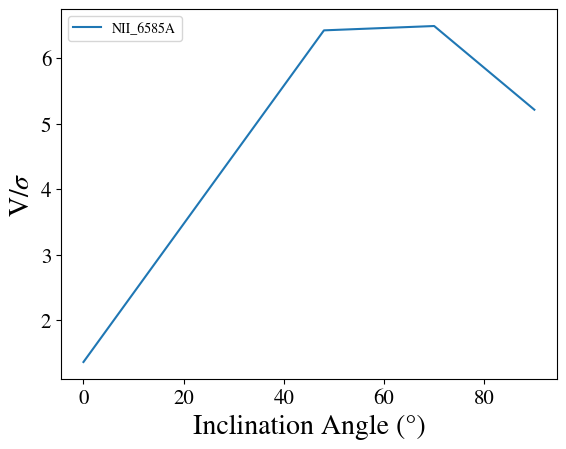

In [10]:
incs = [0, 48, 70, 90]

#plt.plot(incs, CII_vsigma, label = "CII_158mu")
#plt.plot(incs, CO_vsigma, label = "CO_J10")
#plt.plot(incs, OIII_vsigma, label = "OIII_5007A")
plt.plot(incs, NII_vsigma, label = "NII_6585A")


plt.xlabel("Inclination Angle (°)", fontsize = 20)
plt.ylabel("V/$\sigma$", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()

plt.show()